# Chapter 13 Robust machine learning with ML Pipelines
This chapter covers

- Using transformers and estimators to transform data into ML features
- Assembling features into a vector through an ML pipeline
- Training a simple ML model
- Evaluating a model using relevant performance metrics
- Optimizing a model using cross-validation
- Interpreting a model’s decision-making process through feature weights

[Spark MLlib Guide](https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier)

# Python Sklearn Pipeline Example

In [1]:
# Import necessary libraries
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
data = load_iris()
X, y = data.data, data.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with a scaler and logistic regression model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])

# Hyperparameters to tune and their possible values
param_grid = {
    'classifier__C': np.logspace(-4, 4, 20),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
}

# Use GridSearchCV to find the best hyperparameters
clf = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=0, n_jobs=-1)

# Fit model
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Best Hyperparameters:", clf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best Hyperparameters: {'classifier__C': 11.288378916846883, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



/home/sli/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Create a spark session

In [3]:
import sys
from pyspark.sql import SparkSession
from pyspark.sql.utils import AnalysisException
import pyspark.sql.functions as F
import pyspark.sql.types as T
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# change the account name to your email account
account='sli'

# define a root path to access the data in the DataAnalysisWithPythonAndPySpark
root_path='/net/clusterhn/home/'+account+'/isa460/Data/'

# append path to helper_functions to system path
sys.path.append('/net/clusterhn/home/sli/isa460_sli')

import helper_functions as H

# check if the Spark session is active. If it is activate, close it

try:
    if spark:
        spark.stop()
except:
    pass    

spark = (SparkSession.builder.appName("Multidimensional Data Frame")
        .config("spark.port.maxRetries", "200")
        .config("spark.sql.mapKeyDedupPolicy", "LAST_WIN")  # This configuration allow the duplicate keys in the map data type.
        .config("spark.driver.memory", "8g")
        .getOrCreate())

# confiture the log level (defaulty is WARN)
spark.sparkContext.setLogLevel('ERROR')

# Transformers and estimators: The building blocks of ML in Spark

In [4]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

CONTINUOUS_NB = ["rating", "calories_i", "protein_i", "fat_i", "sodium_i"]
 
continuous_assembler = VectorAssembler(
    inputCols=CONTINUOUS_NB, outputCol="continuous"
)
 
continuous_scaler = MinMaxScaler(
    inputCol="continuous",
    outputCol="continuous_scaled",
)

## Data comes in, data comes out: The Transformer

In [5]:
print(continuous_assembler.outputCol)

VectorAssembler_3bf09112e586__outputCol


In [6]:
# get the value of a specific param
print(continuous_assembler.getOutputCol())

continuous


In [7]:
# see all the Params at once
print(continuous_assembler.explainParam("outputCol"))

outputCol: output column name. (default: VectorAssembler_3bf09112e586__output, current: continuous)


In [8]:
# see multuiple Params
print(continuous_assembler.explainParams())

handleInvalid: How to handle invalid data (NULL and NaN values). Options are 'skip' (filter out rows with invalid data), 'error' (throw an error), or 'keep' (return relevant number of NaN in the output). Column lengths are taken from the size of ML Attribute Group, which can be set using `VectorSizeHint` in a pipeline before `VectorAssembler`. Column lengths can also be inferred from first rows of the data since it is safe to do so but only in case of 'error' or 'skip'). (default: error)
inputCols: input column names. (current: ['rating', 'calories_i', 'protein_i', 'fat_i', 'sodium_i'])
outputCol: output column name. (default: VectorAssembler_3bf09112e586__output, current: continuous)


### SETTING PARAMS OF AN INSTANTIATED TRANSFORMER USING GETTERS AND SETTERS

In [9]:
# set param
continuous_assembler.setOutputCol("more_continuous")
  
print(continuous_assembler.getOutputCol())

more_continuous


In [10]:
# set multiple params

continuous_assembler.setParams(
    inputCols=["one", "two", "three"], handleInvalid="skip"
)
print(continuous_assembler.explainParams())

handleInvalid: How to handle invalid data (NULL and NaN values). Options are 'skip' (filter out rows with invalid data), 'error' (throw an error), or 'keep' (return relevant number of NaN in the output). Column lengths are taken from the size of ML Attribute Group, which can be set using `VectorSizeHint` in a pipeline before `VectorAssembler`. Column lengths can also be inferred from first rows of the data since it is safe to do so but only in case of 'error' or 'skip'). (default: error, current: skip)
inputCols: input column names. (current: ['one', 'two', 'three'])
outputCol: output column name. (default: VectorAssembler_3bf09112e586__output, current: more_continuous)


In [11]:
# clear Param
continuous_assembler.clear(continuous_assembler.handleInvalid)
 
print(continuous_assembler.getHandleInvalid())

error


## Data comes in, transformer comes out: The Estimator

# Building a (complete) machine learning pipeline

## load processed data from Chapter 12

In [12]:
food=spark.read.parquet(root_path+'recipes/recipes_cleaned')

# find all columns that only have only 1 or 1 value
def columns_with_only_0_and_1(df):
    return [c for c in df.columns if sorted(df.agg(F.collect_set(c)).first()[0]) == [0, 1]]

BINARY_COLUMNS=columns_with_only_0_and_1(food)

# remove target desset from BINARY_COLUMNS

BINARY_COLUMNS.remove('dessert')

In [14]:
#BINARY_COLUMNS

## food_pipeline pipeline, containing three stages

In [15]:
from pyspark.ml import Pipeline
import pyspark.ml.feature as MF
 
imputer = MF.Imputer(                        
    strategy="mean",
    inputCols=["rating", "calories", "protein", "fat", "sodium"],
    outputCols=["rating_i", "calories_i", "protein_i", "fat_i", "sodium_i"],
)
 
continuous_assembler = MF.VectorAssembler(  
    inputCols=["rating_i", "calories_i", "protein_i", "fat_i", "sodium_i"],
    outputCol="continuous",
)
 
continuous_scaler = MF.MinMaxScaler(         
     inputCol="continuous",
   outputCol="continuous_scaled",
)
 
food_pipeline = Pipeline(                    
     stages=[imputer, continuous_assembler, continuous_scaler]
)

## Assembling the final data set with the vector column type

In [16]:
preml_assembler = MF.VectorAssembler(
    inputCols=BINARY_COLUMNS                         
    + ["continuous_scaled"]
    + ["protein_ratio", "fat_ratio"],
    outputCol="features",
)
 
food_pipeline.setStages(
    [imputer, continuous_assembler, continuous_scaler, preml_assembler]
)
 
food_pipeline_model = food_pipeline.fit(food)        
food_features = food_pipeline_model.transform(food)

In [19]:
food_features.select("dessert", "features").show(5, truncate=100)

# Note: Since we have 513 elements in our vector, with a majority of zeroes, 
# PySpark uses a sparse vector representation to save some space.

+-------+----------------------------------------------------------------------------------------------------+
|dessert|                                                                                            features|
+-------+----------------------------------------------------------------------------------------------------+
|    0.0|(680,[9,32,144,231,409,418,487,674,675,676,677,678,679],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.1067839195...|
|    0.0|(680,[57,119,157,171,205,265,305,309,324,339,341,452,461,541,559,573,615,623,633,635,653,673,674,...|
|    0.0|(680,[57,119,207,247,267,275,339,341,358,633,635,674,675,677,678],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1....|
|    0.0|(680,[16,171,178,229,260,309,347,389,452,517,519,573,616,620,623,633,635,673,674,675,676,677,678,...|
|    0.0|(680,[16,116,171,178,309,310,325,404,431,444,452,568,573,593,623,653,673,674,675,676,677,678,679]...|
+-------+----------------------------------------------------------------------------------------------------+
o

In [21]:
# chcck the labels for each feature
#food_features.schema["features"].metadata

## Training an ML model using a LogisticRegression classifier

In [22]:
from pyspark.ml.classification import LogisticRegression
 
lr = LogisticRegression(
    featuresCol="features", labelCol="dessert", predictionCol="prediction"
)
 
food_pipeline.setStages(
    [
        imputer,
        continuous_assembler,
        continuous_scaler,
        preml_assembler,
        lr,
     ]
)

Pipeline_e58350797c96

In [23]:
# split data into train and test set
train, test = food.randomSplit([0.7, 0.3], 13)

# cache train set in memory
train.cache()

# train the pipeline model using fit

food_pipeline_model = food_pipeline.fit(train)

# evaluate the model using transform
results = food_pipeline_model.transform(test) 

In [15]:
# check prediction result

results.select("dessert", "prediction", "rawPrediction", "probability").show(3, False)

+-------+----------+----------------------------------------+------------------------------------------+
|dessert|prediction|rawPrediction                           |probability                               |
+-------+----------+----------------------------------------+------------------------------------------+
|1.0    |1.0       |[-14.457074877136183,14.457074877136183]|[5.264679380571837E-7,0.999999473532062]  |
|0.0    |0.0       |[6.616327380061065,-6.616327380061065]  |[0.9986634516178716,0.0013365483821283775]|
|0.0    |0.0       |[0.6102071857759856,-0.6102071857759856]|[0.6479880625083543,0.3520119374916457]   |
+-------+----------+----------------------------------------+------------------------------------------+
only showing top 3 rows



## Evaluating and optimizing our model

## Assessing model accuracy: Confusion matrix and evaluator object

In [24]:
results.groupby("dessert").pivot("prediction").count().show()

+-------+----+----+
|dessert| 0.0| 1.0|
+-------+----+----+
|    0.0|4905| 108|
|    1.0|  78|1013|
+-------+----+----+



In [26]:
# accouracy, precision, recall, f1 score

results2=results.groupby("dessert").pivot("prediction").count().collect()
results2

[Row(dessert=0.0, 0.0=4905, 1.0=108), Row(dessert=1.0, 0.0=78, 1.0=1013)]

In [27]:
TN=results2[0][1]
FP=results2[0][2]
FN=results2[1][1]
TP=results2[1][2]

accuracy=(TP+TN)/(TP+FP+TN+FN)
precision=TP/(TP+FP)
recall=TP/(TP+FN)
f1=2*(precision*recall)/(precision+recall)

print(accuracy, precision, recall, f1)

0.9695281782437746 0.903657448706512 0.928505957836847 0.9159132007233273


In [28]:
# use classification_report from python

from sklearn.metrics import accuracy_score, classification_report

df=results.select('dessert', 'prediction').toPandas()
label=df['dessert']
pred=df['prediction']

print("Accuracy:", accuracy_score(label, pred))
print("\n", classification_report(label, pred))

Accuracy: 0.9695281782437746

               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      5013
         1.0       0.90      0.93      0.92      1091

    accuracy                           0.97      6104
   macro avg       0.94      0.95      0.95      6104
weighted avg       0.97      0.97      0.97      6104



In [29]:
# user the model evaluate
lr_model = food_pipeline_model.stages[-1]

# input is target variable and feature
metrics = lr_model.evaluate(results.select("dessert", "features"))

# LogisticRegressionTrainingSummary
 
print(f"Model precision: {metrics.precisionByLabel[1]}") 
print(f"Model recall: {metrics.recallByLabel[1]}")  

Model precision: 0.903657448706512
Model recall: 0.928505957836847


### True positives vs. false positives: The ROC curve

In [30]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
 
evaluator = BinaryClassificationEvaluator(
    labelCol="dessert",                     
    rawPredictionCol="rawPrediction",      
    metricName="areaUnderROC",
)
 
accuracy = evaluator.evaluate(results)
print(f"Area under ROC = {accuracy} ")

Area under ROC = 0.990934112096816 


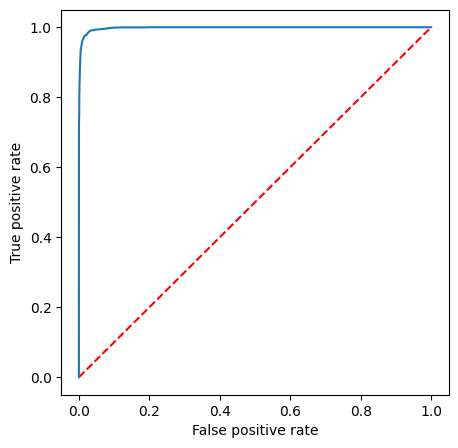

In [31]:
# plot roc curve
import matplotlib.pyplot as plt
lr_model = food_pipeline_model.stages[-1]

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], "r--")
plt.plot(
    lr_model.summary.roc.select("FPR").collect(),
    lr_model.summary.roc.select("TPR").collect(),
)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

## Optimizing hyperparameters with cross-validation

In [35]:
# explain the parameters of the model

#lr.explainParams()

In [36]:
# Using ParamGridBuilder to define a set of hyperparameters
from pyspark.ml.tuning import ParamGridBuilder
 
grid_search = (
    ParamGridBuilder()                          
    .addGrid(lr.elasticNetParam, [0.0, 1.0])    
    .build()                                    
)

In [37]:
# Creating and using a CrossValidator object
from pyspark.ml.tuning import CrossValidator
 
cv = CrossValidator(
    estimator=food_pipeline,
    estimatorParamMaps=grid_search,
    evaluator=evaluator,
    numFolds=3,
    seed=13,
    collectSubModels=True,
)
 
cv_model = cv.fit(train)                     
 
print(cv_model.avgMetrics)
 
pipeline_food_model = cv_model.bestModel

[0.9875034780454538, 0.9875019327464538]


## Getting the biggest drivers from our model: Extracting the coefficients

In [38]:
import pandas as pd
 
feature_names = ["(Intercept)"] + [                   
    x["name"]
    for x in (
        food_features
        .schema["features"]
        .metadata["ml_attr"]["attrs"]["numeric"]
    )
]
feature_coefficients = [lr_model.intercept] + list(     
    lr_model.coefficients.values
)
 
 
coefficients = pd.DataFrame(
    feature_coefficients, index=feature_names, columns=["coef"]
)
 
coefficients["abs_coef"] = coefficients["coef"].abs()
 
print(coefficients.sort_values(["abs_coef"], ascending=False)[0:20])

                          coef   abs_coef
pacific_palisades   -63.206055  63.206055
dorie_greenspan     -56.579880  56.579880
nebraska             50.304217  50.304217
waffle              -48.089336  48.089336
bran                -46.324660  46.324660
custard              35.319517  35.319517
labor_day           -30.524357  30.524357
west_virginia       -30.386962  30.386962
cobbler_crumble      25.514033  25.514033
lychee               24.567872  24.567872
martini             -24.552540  24.552540
iced_coffee          24.254396  24.254396
brownie              21.144919  21.144919
crme_de_cacao        20.557091  20.557091
friendsgiving        20.311164  20.311164
tested_and_improved  19.520354  19.520354
cakeweek             18.026695  18.026695
poppy               -17.498760  17.498760
pasta_maker         -17.183964  17.183964
quick_and_healthy   -16.635419  16.635419


## Save the pipeline mode for future use

In [39]:
pipeline_food_model.write().overwrite().save("dessert_model_logisticsRegression")

In [40]:
## Load the model

from pyspark.ml.pipeline import PipelineModel
 
loaded_model = PipelineModel.load("dessert_model_logisticsRegression")

In [46]:
# use the model to make prediction

food=spark.read.parquet(root_path+'recipes/recipes_cleaned')

loaded_model.transform(food).select('dessert', 'prediction').show()

+-------+----------+
|dessert|prediction|
+-------+----------+
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       1.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       1.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
+-------+----------+
only showing top 20 rows



In [ ]:
# Note to make the above model works, you need to have BINARY_COLUMNS already defined.
# find all columns that only have only 1 or 1 value
def columns_with_only_0_and_1(df):
    return [c for c in df.columns if sorted(df.agg(F.collect_set(c)).first()[0]) == [0, 1]]

BINARY_COLUMNS=columns_with_only_0_and_1(food)

# remove target desset from BINARY_COLUMNS

BINARY_COLUMNS.remove('dessert')

# Summary

- Transformers are objects that, through a transform() method, modify a data frame based on a set of Params that drives its behavior. We use a transformer stage when we want to deterministically transform a data frame.
- Estimators are objects that, through a fit() method, take a data frame and return a fully parameterized transformer called a model. We use an estimator stage when we want to transform a data frame using a data-dependent transformer.
- ML pipelines are like estimators, as they use the fit() method to yield a pipeline model. They have a single Param, stages, that carries an ordered list of transformers and estimators to be applied on a data frame.
- Before training a model, every feature needs to be assembled in a vector using the VectorAssembler transformer. This provides a single optimized (sparse or dense) column containing all the features for machine learning.
- PySpark provides useful metrics for model evaluation through a set of evaluator objects. You select the appropriate one based on your type of prediction (binary classification = BinaryClassificationEvaluator).
- With a Param Map grid, an evaluator, and an estimator, we can perform model hyperparameter optimization to try different scenarios and try to improve model accuracy.
- Cross-validation is a technique that resamples the data frame into different partitions before fitting/testing the model. We use cross-validation to test if the model performs consistently when it sees different data.